# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[51, 51, 53, 53, 54, 54, 54, 55, 55, 58, 60, 61, 61, 62, 62, 63, 64, 66, 67, 70, 72, 72, 75, 77, 81, 82, 82, 84, 125, 131]


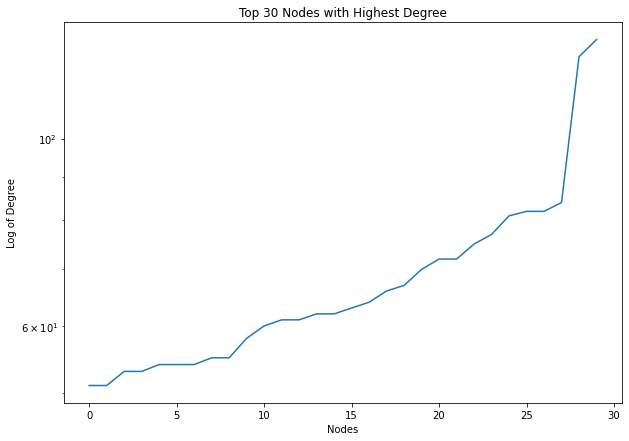

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
plt.semilogy(sorted([B.degree[user] for user in users])[-30:])
print(sorted([B.degree[user] for user in users])[-30:])
plt.show()

In [8]:
#removing structural holes
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        users.remove(user)

autothrall
hells_unicorn


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
            else:
                G.add_edge(genre1, genre2, weight = 1)

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

In [11]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [12]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [13]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [14]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [15]:
G3 = G.copy()

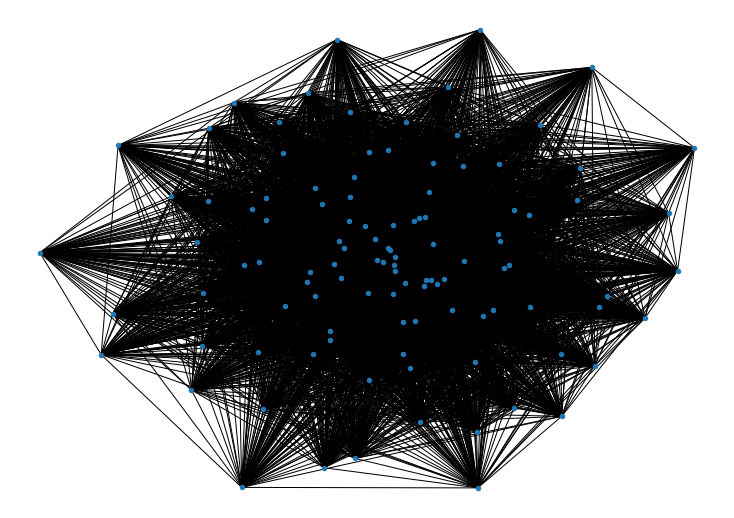

In [16]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
nx.draw(Core, node_size = 20)

In [17]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

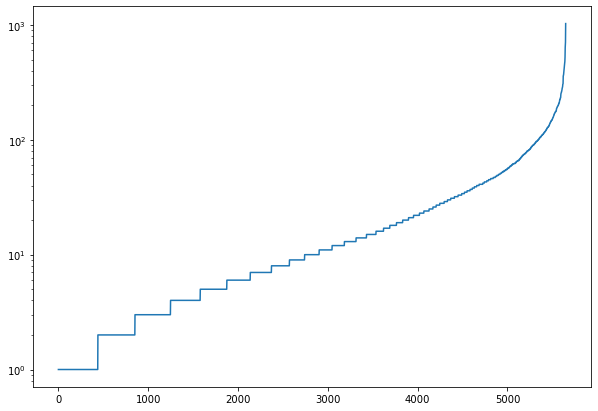

In [18]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))

In [19]:
tmp = sorted(list(nx.get_edge_attributes(Core,'weight').values()))
for i in range(len(tmp)):
    if (tmp[i] == 33):
        print(i)
        break

4450


(array([2136.,  911.,  643.,  330.,  275.,  195.,  167.,  132.,  128.,
          83.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

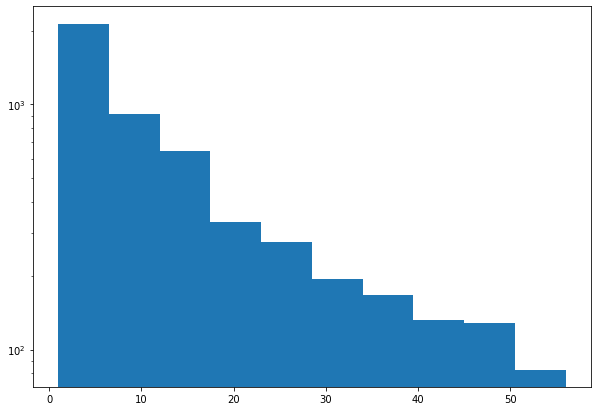

In [20]:
plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

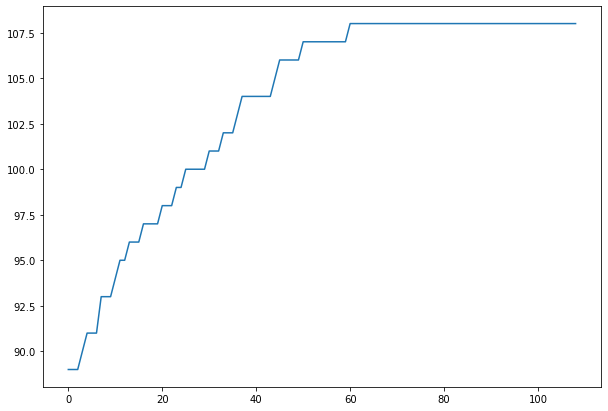

In [21]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='vertical')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.plot([x[0] for x in tmp])
plt.show()

In [22]:
#on hold first
'''G = G3.copy()
G2 = G.copy()
print(list(nx.isolates(G)))

for u,v in G2.edges():
    if G2[u][v]['weight'] < 5: #10 for double counting
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes()'''

"G = G3.copy()\nG2 = G.copy()\nprint(list(nx.isolates(G)))\n\nfor u,v in G2.edges():\n    if G2[u][v]['weight'] < 5: #10 for double counting\n        G.remove_edge(u,v)\n        \nnx.number_connected_components(G)\nprint(clt.Counter([len(cc) for cc in nx.connected_components(G)]))\nprint(list(nx.isolates(G)))\nG.remove_nodes_from(list(nx.isolates(G)))\nG.number_of_nodes()"

In [23]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [24]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [25]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    #print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    #print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

15 1 3 102
16 1 3 100
17 1 2 100
18 1 3 98
19 1 3 98
20 1 2 97
21 1 3 96
22 1 3 92
23 1 3 90
24 1 3 89


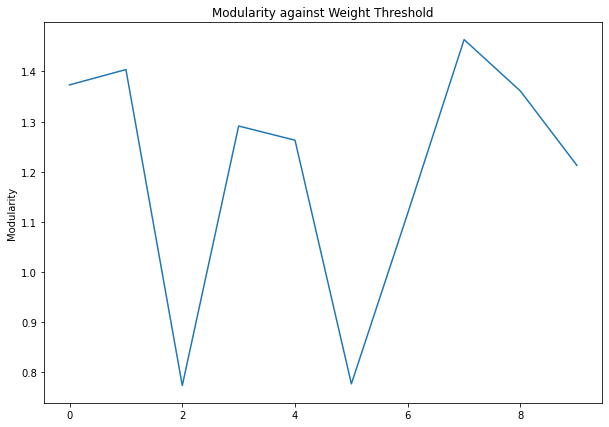

In [26]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()

In [27]:
print(list(enumerate(mods)))

[(0, 1.3732620320855615), (1, 1.40386803185438), (2, 0.7736013986013986), (3, 1.2912280701754386), (4, 1.262905162064826), (5, 0.776908023483366), (6, 1.117291414752116), (7, 1.4636627906976745), (8, 1.3608695652173912), (9, 1.2128851540616246)]


In [28]:
#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()

['djent', 'electro industrial metal', 'gothic black metal', 'extreme avantgarde metal', 'ambient doom metal', 'progressive sludge metal', 'industrial thrash metal', 'extreme industrial metal', 'instrumental post-metal', 'progressive math metal', 'oriental folk metal', 'progressive folk metal']


(97, 1816)

In [29]:
CoreNew = Core

In [30]:
'''tmp = sorted([(v,u) for u,v in G3.degree])[-30:]
plt.xticks(rotation='vertical')
plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.ylabel('Degree')
plt.title('Degree of Top 30 Genres in Network of Genres')
plt.show()
remove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]
print(remove_genres)
#G.remove_nodes_from(remove_genres)'''

"tmp = sorted([(v,u) for u,v in G3.degree])[-30:]\nplt.xticks(rotation='vertical')\nplt.plot([x[1] for x in tmp],[x[0] for x in tmp])\nplt.ylabel('Degree')\nplt.title('Degree of Top 30 Genres in Network of Genres')\nplt.show()\nremove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]\nprint(remove_genres)\n#G.remove_nodes_from(remove_genres)"

In [31]:
#H = G.copy()
H = CoreNew.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

In [32]:
partitions = [cc for cc in nx.connected_components(H)]

In [33]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [CoreNew.subgraph(comp) for comp in comps]
    ave_weight = [sum([CoreNew[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([CoreNew[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([CoreNew[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev

In [34]:
[len(cc) for cc in partitions]

[48, 50, 11]

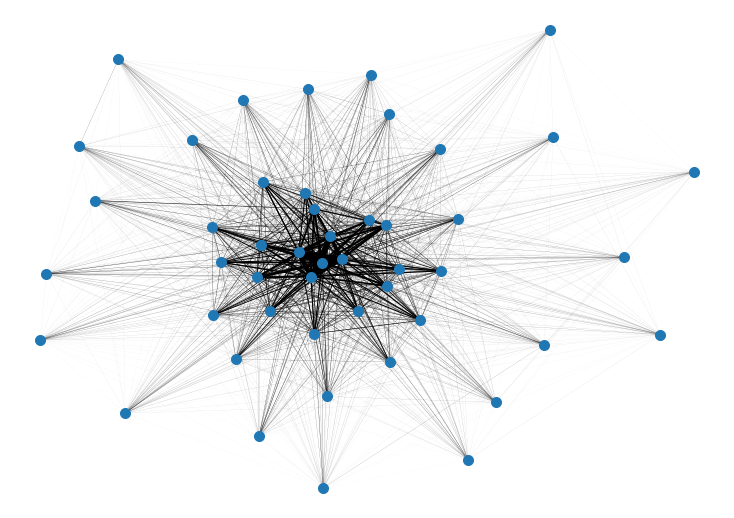

In [77]:
cluster = CoreNew.subgraph(list(nx.connected_components(H))[0])
nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()

In [35]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev
0,"{industrial progressive metal, heavy metal, ne...",48,25.234534,24.227837,0.960106,54.810346
1,"{blackened sludge metal, gothic metal, industr...",50,22.050707,21.654694,0.982041,29.144492
2,"{progressive deathcore, technical deathcore, t...",11,112.872727,112.872727,1.000000,165.630701


In [47]:
clusters = []
clusters.append(G.subgraph(list(nx.connected_components(H))[2]))

In [48]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = CoreNew.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters.append(CoreNew.subgraph(comp))

In [49]:
breakDown([0,1])

End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev
0,"{heavy metal, progressive metalcore, progressi...",21,60.908213,60.038095,0.985714,106.320345
1,"{industrial progressive metal, progressive slu...",27,9.924925,9.415954,0.948718,12.105284


End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev
0,"{folk doom metal, death doom metal, atmospheri...",6,24.000000,24.000000,1.000000,30.086542
1,"{gothic metal, industrial black metal, experim...",25,19.789831,19.460000,0.983333,23.567499
2,"{shoegaze, post-metal, experimental black meta...",8,38.714286,38.714286,1.000000,30.775520
3,"{blackened sludge metal, doom metal, stoner ro...",11,35.727273,35.727273,1.000000,55.010893


112.87272727272727


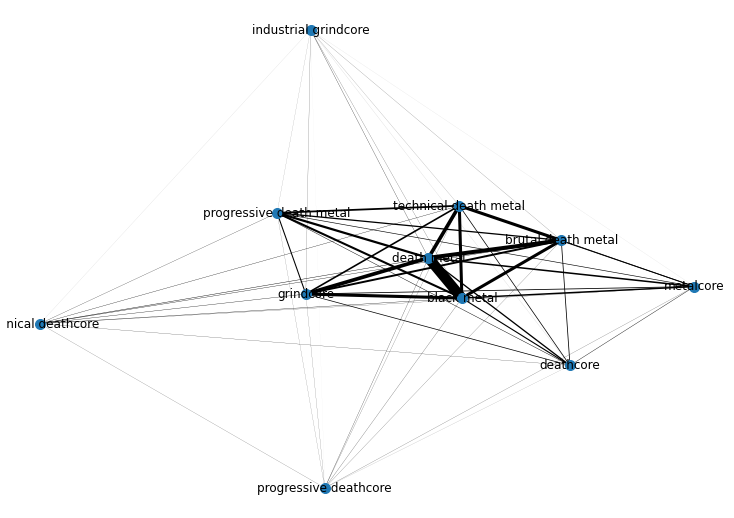

60.908212560386474


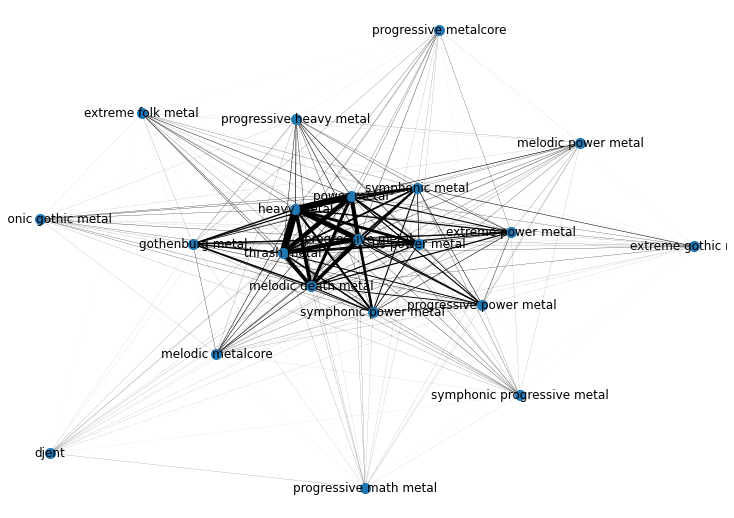

9.924924924924925


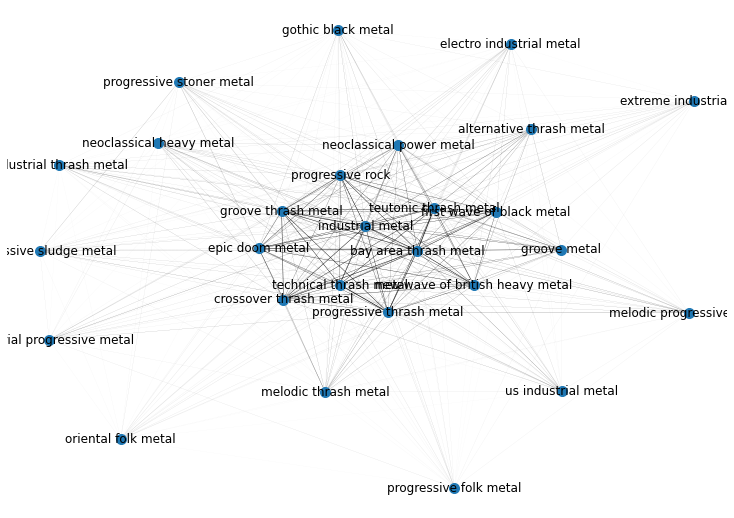

24.0


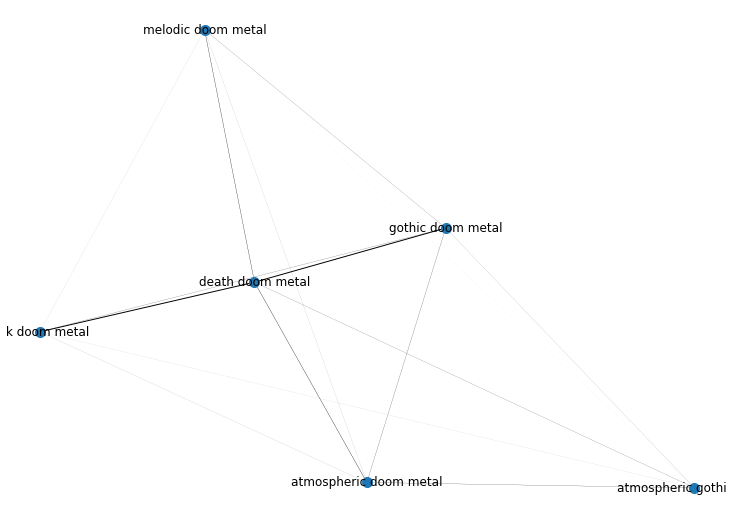

19.789830508474576


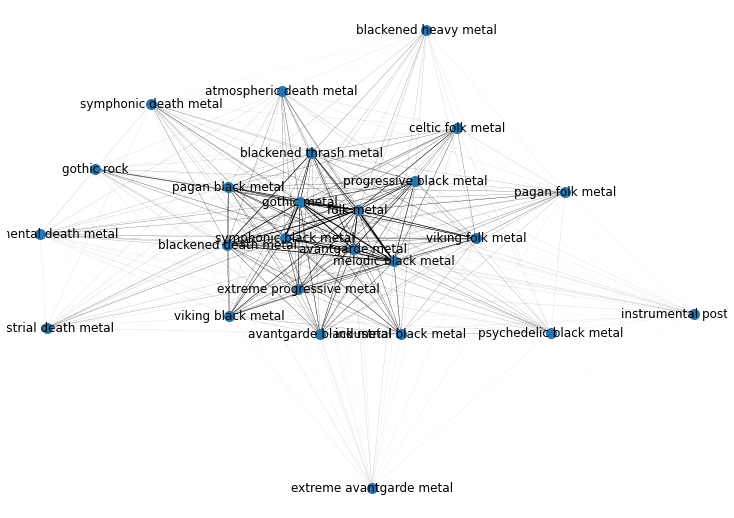

38.714285714285715


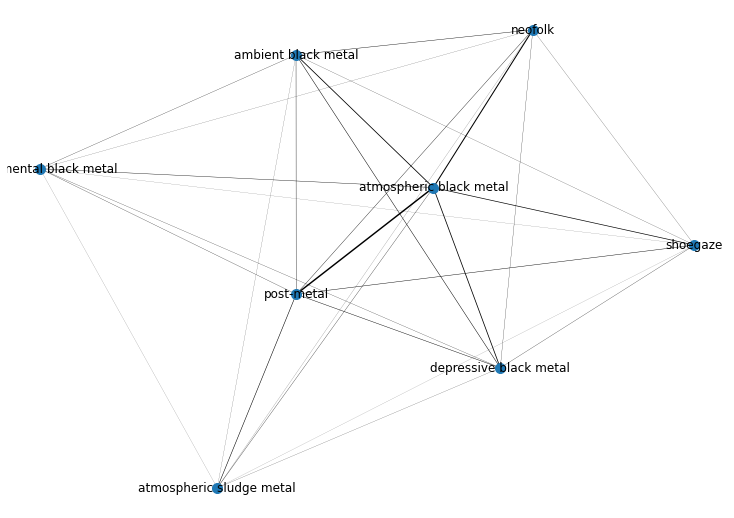

35.72727272727273


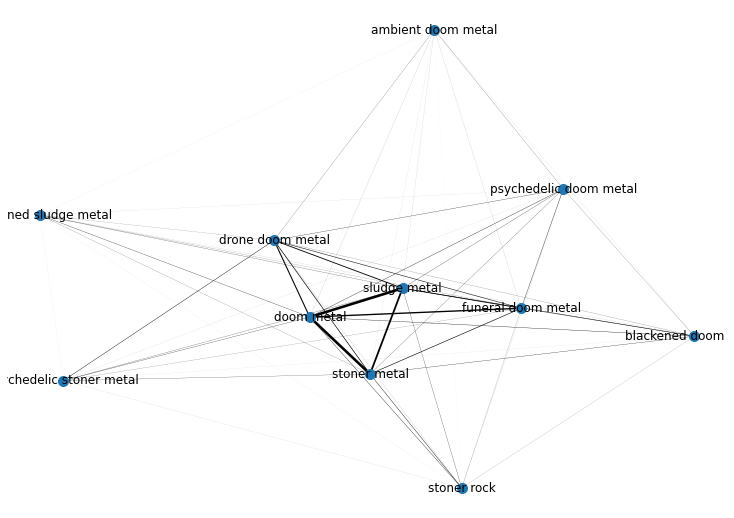

In [73]:
for cluster in clusters:
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()

In [69]:
x = 'folk doom metal'
w = sorted([(CoreNew[x][u]['weight'],u) for u in list(CoreNew[x])])
w

[(1, 'blackened sludge metal'),
 (1, 'extreme industrial metal'),
 (1, 'industrial death metal'),
 (1, 'industrial progressive metal'),
 (2, 'djent'),
 (2, 'extreme avantgarde metal'),
 (2, 'extreme folk metal'),
 (2, 'gothic black metal'),
 (2, 'melodic progressive metal'),
 (2, 'melodic thrash metal'),
 (2, 'progressive deathcore'),
 (2, 'progressive stoner metal'),
 (3, 'alternative thrash metal'),
 (3, 'blackened heavy metal'),
 (3, 'electro industrial metal'),
 (3, 'industrial grindcore'),
 (3, 'instrumental post-metal'),
 (3, 'progressive math metal'),
 (3, 'stoner rock'),
 (3, 'symphonic gothic metal'),
 (3, 'symphonic progressive metal'),
 (4, 'atmospheric death metal'),
 (4, 'atmospheric gothic metal'),
 (4, 'gothic rock'),
 (4, 'melodic doom metal'),
 (4, 'neoclassical heavy metal'),
 (4, 'progressive metalcore'),
 (4, 'psychedelic doom metal'),
 (5, 'avantgarde black metal'),
 (5, 'celtic folk metal'),
 (5, 'industrial black metal'),
 (5, 'psychedelic black metal'),
 (5, 'ps

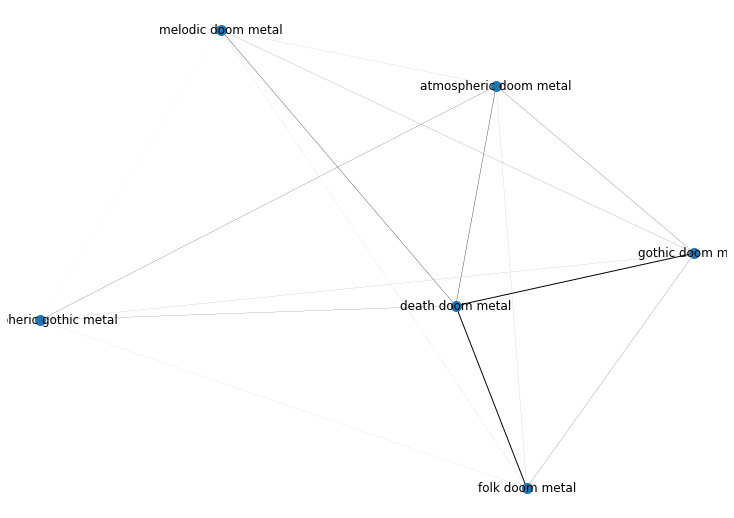

In [71]:
cluster = clusters[3]
nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()

In [53]:
CoreNew['progressive death metal']['brutal death metal']

{'weight': 128}

In [40]:
'''G3.remove_edges_from(nx.selfloop_edges(G3))
NewAb = nx.k_core(G3)
nx.draw(NewAb.subgraph(list(nx.connected_components(Ab))[0]), node_size = 20)'''

'G3.remove_edges_from(nx.selfloop_edges(G3))\nNewAb = nx.k_core(G3)\nnx.draw(NewAb.subgraph(list(nx.connected_components(Ab))[0]), node_size = 20)'

In [41]:
'''def possible(node):
    if node not in genre_group or genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        return False
    else:
        return True
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if len(genre_list) > 1:
        for i in range(len(genre_list)-1):
            for j in range(i+1,len(genre_list)):
                if not possible(genre_list[i]) or not possible(genre_list[j]):
                    continue
                if not Ab.has_edge(genre_list[i],genre_list[j]):
                    Ab.add_edge(genre_list[i],genre_list[j], weight = 1)
                else:
                    Ab[genre_list[i]][genre_list[j]]['weight'] += 1

nx.draw(Ab.subgraph(list(nx.connected_components(Ab))[0]), node_size = 20)'''

"def possible(node):\n    if node not in genre_group or genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':\n        return False\n    else:\n        return True\n#construction of bipartite graph\ngenres = set()\nusers = set()\nposScore = 75\ndef isNaN(x):\n    return x != x\nfor index,row in df.iterrows():\n    if row['Score'] < posScore: #removing reviews with low score \n        continue\n    if isNaN(row['Combined_Genre']):\n        continue\n    genre_list = row['Combined_Genre'].split('|')\n    if len(genre_list) > 1:\n        for i in range(len(genre_list)-1):\n            for j in range(i+1,len(genre_list)):\n                if not possible(genre_list[i]) or not possible(genre_list[j]):\n                    continue\n                if not Ab.has_edge(genre_list[i],genre_list[j]):\n                    Ab.add_edge(genre_list[i],genre_list[j], weight = 1)\n                else:\n                    Ab[genre_list[i]][genre_list[j]]['weight'] += 1\n\nnx.draw(Ab.subgr

In [42]:
'''#Calculating betweenness values for edges
bb = nx.edge_betweenness_centrality(G, normalized=True)
nx.set_edge_attributes(G, bb, 'betweenness')
for u,v in G.edges:
    G[u][v]['width'] = (1 - G[u][v]['betweenness']) #larger betweenness, more likely to be eliminated, hence lower width

tmp = list(nx.get_edge_attributes(G,'width').values())
maxi, mini = max(tmp), min(tmp)
print(maxi,mini)

G2 = G.copy()

for u,v in G2.edges:
    G[u][v]['width'] = ((G2[u][v]['width']-mini + 1)/(maxi-mini))*G2[u][v]['weight'] #width = (1-betweenness)*weight

#Thresholding
G2 = G.copy()
print(list(nx.isolates(G)))

for u,v in G2.edges():
    if G2[u][v]['width'] < 100: 
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes()'''

"#Calculating betweenness values for edges\nbb = nx.edge_betweenness_centrality(G, normalized=True)\nnx.set_edge_attributes(G, bb, 'betweenness')\nfor u,v in G.edges:\n    G[u][v]['width'] = (1 - G[u][v]['betweenness']) #larger betweenness, more likely to be eliminated, hence lower width\n\ntmp = list(nx.get_edge_attributes(G,'width').values())\nmaxi, mini = max(tmp), min(tmp)\nprint(maxi,mini)\n\nG2 = G.copy()\n\nfor u,v in G2.edges:\n    G[u][v]['width'] = ((G2[u][v]['width']-mini + 1)/(maxi-mini))*G2[u][v]['weight'] #width = (1-betweenness)*weight\n\n#Thresholding\nG2 = G.copy()\nprint(list(nx.isolates(G)))\n\nfor u,v in G2.edges():\n    if G2[u][v]['width'] < 100: \n        G.remove_edge(u,v)\n        \nnx.number_connected_components(G)\nprint(clt.Counter([len(cc) for cc in nx.connected_components(G)]))\nprint(list(nx.isolates(G)))\nG.remove_nodes_from(list(nx.isolates(G)))\nG.number_of_nodes()"